In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py
import healpy as hp

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle 
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib.patches import Polygon
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
def orbpole(xs,vs):
    uu = np.cross(xs, vs)
    uumag = np.linalg.norm(uu)
    u = uu.T/uumag
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb    

def orbpole_singlevec(u):
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb  

In [3]:
lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
disc_xs, disc_vs = Model.expansion_centres(0.)[:3], Model.expansion_centre_velocities(0.)[:3]

lmc_lpole, lmc_bpole = orbpole(np.array(lmc_xs), np.array(lmc_vs))
disc_lpole, disc_bpole = orbpole(np.array(disc_xs), np.array(disc_vs))
com_lpole, com_bpole = orbpole_singlevec(disc_xs)

def rotation_matrix_from_vectors(v1, v2):
    # Normalize the vectors
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Calculate the cosine and sine of the angle between the vectors
    cos_theta = np.dot(v1, v2)
    sin_theta = np.cross(v1, v2)
    
    # Construct the rotation matrix
    R = np.array([[cos_theta, -sin_theta],
                  [sin_theta, cos_theta]])
    return R

# Example usage
v1_lmc = np.array([lmc_lpole, lmc_bpole])
v1_disc = np.array([disc_lpole, disc_bpole])
v1_com = np.array([com_lpole, com_bpole])
v2 = np.array([0, 90])

rotation_matrix_lmc = rotation_matrix_from_vectors(v1_lmc, v2)
rotation_matrix_disc = rotation_matrix_from_vectors(v1_disc, v2)
rotation_matrix_disc = rotation_matrix_from_vectors(v1_com, v2)
rotation_matrix_lmc, rotation_matrix_disc, rotation_matrix_disc

(array([[-0.02130971, -0.99977292],
        [ 0.99977292, -0.02130971]]),
 array([[-0.56870386, -0.82254235],
        [ 0.82254235, -0.56870386]]),
 array([[-0.56870386, -0.82254235],
        [ 0.82254235, -0.56870386]]))

### Mollweide projections of orbital poles

In [4]:
def mollewide_poles(path_data, pots, pot_labels, plotname, frame, cbar, savefig=False):

    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]

    fig, ax = plt.subplots(5, 2, subplot_kw={'projection': 'mollweide'}, figsize=(14, 19))

    plt.subplots_adjust(hspace=-0.1, wspace=0.1)

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            t_idx = -1
            ds = np.array(file['ds'])
            rlmc = np.array(file['lmc_sep'])
            loc_veldis = np.array(file['loc_veldis'])
            l_pole = np.array(file['pole_l'])[:,t_idx]
            b_pole = np.array(file['pole_b'])[:,t_idx]
            lons = np.array(file['lons'])
        
        print("Plotting for potential: {}".format(potentials[j]))
        plt.sca(ax[pltidx[j]])
        plt.grid(alpha=.25)
        rng = np.random.default_rng(seed=1)
        Nstreams, Nparticles = 100, 500
        Nsample = (Nstreams, Nparticles)

        l_poles_sample = rng.choice(l_pole, axis=0, size=Nsample[0])
        b_poles_sample = rng.choice(b_pole, axis=0, size=Nsample[0])
        lons_sample = rng.choice(lons, axis=0, size=Nsample[0])
        rlmc_sample = rng.choice(rlmc, axis=0, size=Nsample[0])
        ds_sample = rng.choice(ds, size=Nsample[0])
        ds_cbar = np.repeat(ds_sample, Nparticles)
        
        l_poles_sample_red = rng.choice(l_poles_sample, axis=1, size=Nsample[1])
        b_poles_sample_red = rng.choice(b_poles_sample, axis=1, size=Nsample[1])
        lons_sample_red = rng.choice(lons_sample, axis=1, size=Nsample[1])
        rlmc_sample_red = rng.choice(rlmc_sample, axis=1, size=Nsample[1])
        
        if frame=='LMC':

            poles =  np.stack((l_poles_sample_red, b_poles_sample_red))
            rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_poles_sample_red))])
            
        if frame =='disc':
            
            poles =  np.stack((l_poles_sample_red, b_poles_sample_red))
            rot_pole = np.array([rotation_matrix_disc @ poles[:,i] for i in range(len(l_poles_sample_red))])

        sample_ls = rot_pole[:,0]*u.deg 
        wrapped_sample_ls_i = np.where(sample_ls.value>=180, sample_ls.value - 360, sample_ls.value)
        wrapped_sample_ls = np.where(wrapped_sample_ls_i<=-180, wrapped_sample_ls_i + 360, wrapped_sample_ls_i)

        sample_bs = rot_pole[:,1]*u.deg 
        wrapped_sample_bs = np.where(sample_bs.value>=90, sample_bs.value - 180, sample_bs.value)
   
        if cbar=='distance':
            
            sc=plt.scatter( (wrapped_sample_ls)*u.deg.to(u.rad), (wrapped_sample_bs)*u.deg.to(u.rad),s=2,
              c=ds_cbar, vmin=5, vmax=80, cmap='plasma_r', rasterized=True)
            
            plt.scatter(0, (90*u.deg).to(u.rad), s=100,
                        edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)
            
            # plt.scatter((disc_lpole*u.deg + lpole_corr).to(u.rad), (disc_bpole*u.deg + bpole_corr).to(u.rad), s=100,
            #     edgecolors='k', facecolor='r',marker='o', label='Disc', rasterized=True)
            
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\mathbf{r}_\mathrm{gal}\,[\mathrm{kpc}]$')
            cb.ax.tick_params(labelsize=12)
            
        if cbar=='lon_frac':
            
            sc=plt.scatter((wrapped_sample_ls)*u.deg.to(u.rad), (wrapped_sample_bs)*u.deg.to(u.rad), 
               c=lons_sample_red/180, cmap='coolwarm',s=2,rasterized=True,
              norm=SymLogNorm(linthresh=0.01, linscale=0.00001, vmin=-1, vmax=1))

            plt.scatter(0, (90*u.deg).to(u.rad), s=100,
                         edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)
            
            # plt.scatter((disc_lpole*u.deg + lpole_corr).to(u.rad), (disc_bpole*u.deg + bpole_corr).to(u.rad), s=100,
            #     edgecolors='k', facecolor='r',marker='o', label='Disc', rasterized=True)

            plt.scatter(((wrapped_sample_ls)*u.deg.to(u.rad))[:,0], ((wrapped_sample_bs)*u.deg.to(u.rad))[:,0],s=10,
                            edgecolors='k', facecolor='limegreen',marker='o', label='Prog.', rasterized=True)

            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$f_{\mathrm{particle}}(\psi_1)$')
            cb.ax.tick_params(labelsize=12)
            cb.set_ticks([ -0.5, -0.1, 0, 0.1, 0.5 ]) 
            cb.set_ticklabels([ '-0.5','-0.1', '0', '0.1','0.5']) 

        ax[4,1].set_visible(False)

        plt.title(labels[j], loc='left', fontsize=10)
        if j ==0:
            plt.legend(frameon=False, fontsize=7, loc='upper right')
            
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/{}'.format(plotname + '_' + cbar))
    # plt.close()

(1024, 11, 20005)
Plotting for potential: rigid-mw.hdf5
(1024, 11, 20005)
Plotting for potential: static-mw.hdf5
(1024, 11, 20005)
Plotting for potential: rm-MWhalo-full-MWdisc-full-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: em-MWhalo-full-MWdisc-full-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: md-MWhalo-full-MWdisc-full-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: mq-MWhalo-full-MWdisc-full-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: mdq-MWhalo-full-MWdisc-full-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: full-MWhalo-full-MWdisc-no-LMC.hdf5
(1024, 11, 20005)
Plotting for potential: Full-MWhalo-MWdisc-LMC.hdf5


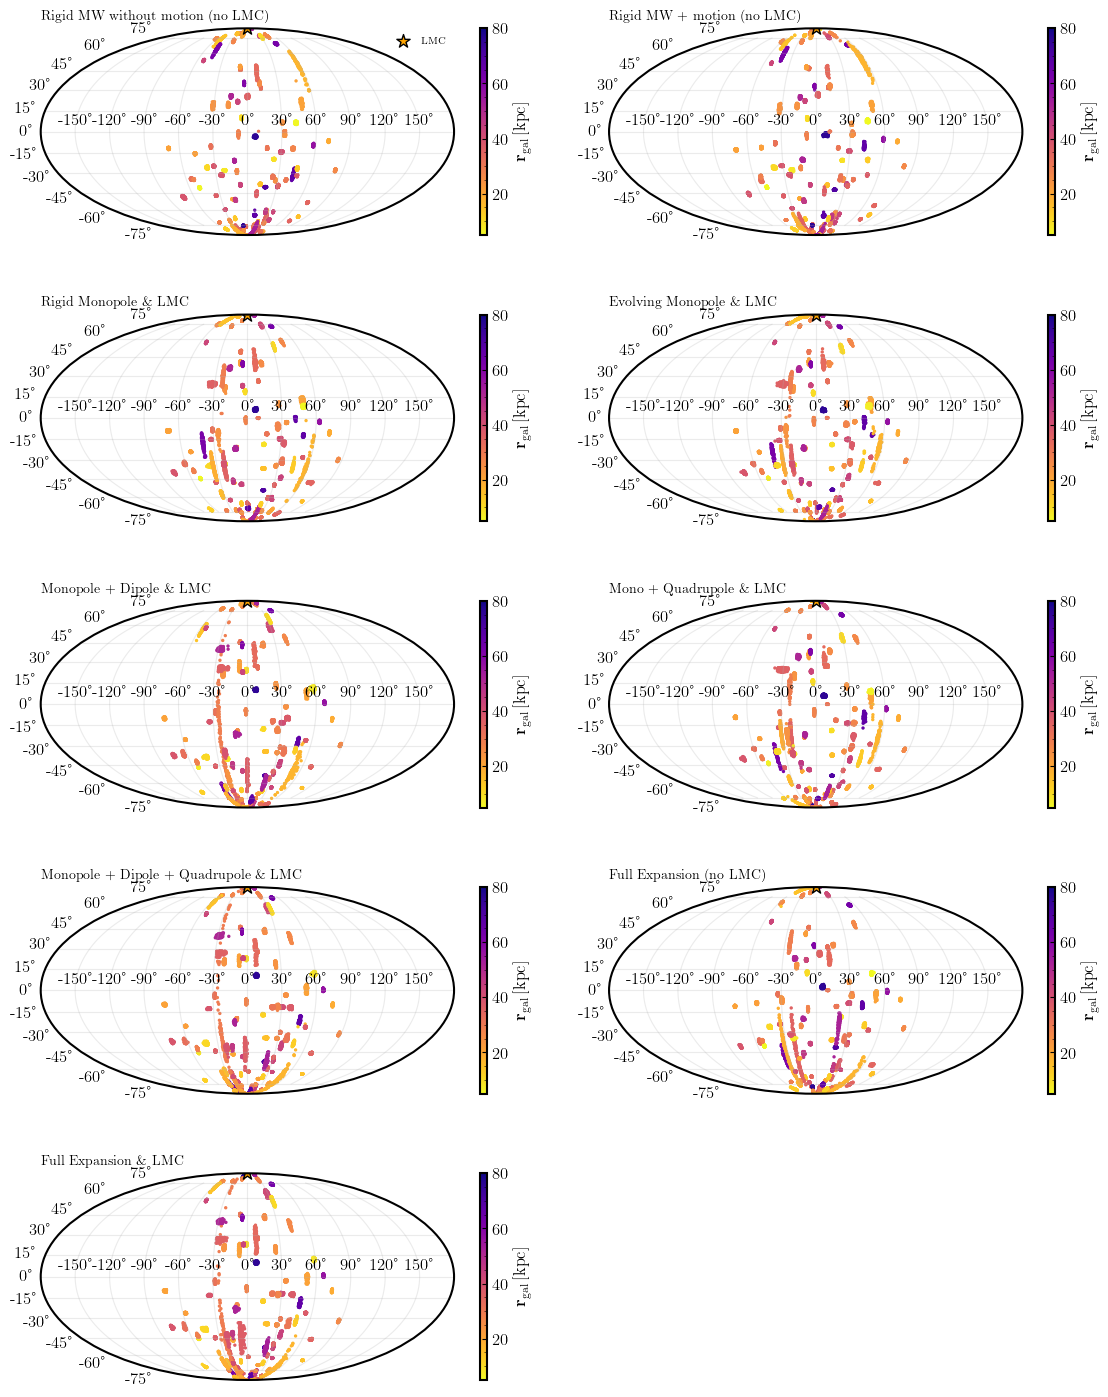

In [55]:
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-5kpcrpmin/'

path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

potentials = list(['rigid-mw.hdf5','static-mw.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                        'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5',])

# potentials = list(['rigid-mw.hdf5',])

labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
       'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

mollewide_poles(path, potentials, labels, 'mollweide_poles_2Gyrago', 'LMC', 'distance', True)

Binned by the progenitor's energy

In [45]:
def mollweide_poles_Ebins(data_path, potential, frame, plotname, savefig=False):
    
    labels = list([r'$\mathcal{E} \in \{-11, -9\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-9, -8\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-8, -7\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-7, -6\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-6, -5\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-5, -4\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$'])
   
    with h5py.File(data_path + potential,'r') as file:

        energies = np.array(file['energies'])
        ds = np.array(file['ds'])
        rlmc = np.array(file['lmc_sep'])
        loc_veldis = np.array(file['loc_veldis'])

        t_idx = -1
        l_pole = np.array(file['pole_l'])[:,t_idx]
        print(l_pole.shape)
        b_pole = np.array(file['pole_b'])[:,t_idx]
        lons = np.array(file['lons'])
    
    # Take a sample of fewer streams and some of their particle
    rng = np.random.default_rng(seed=1)
    Nstreams, Nparticles = 100, 500
    Nsample = (Nstreams, Nparticles)
    
    l_poles_sample = rng.choice(l_pole, axis=0, size=Nsample[0])
    b_poles_sample = rng.choice(b_pole, axis=0, size=Nsample[0])
    lons_sample = rng.choice(lons, axis=0, size=Nsample[0])
    rlmc_sample = rng.choice(rlmc, axis=0, size=Nsample[0])
    energies_sample = rng.choice(energies, axis=0, size=Nsample[0])
    ds_sample = rng.choice(ds, size=Nsample[0])
    # ds_cbar = np.repeat(ds_sample, Nparticles)

    l_poles_sample_red = rng.choice(l_poles_sample, axis=1, size=Nsample[1])
    b_poles_sample_red = rng.choice(b_poles_sample, axis=1, size=Nsample[1])
    lons_sample_red = rng.choice(lons_sample, axis=1, size=Nsample[1])
    rlmc_sample_red = rng.choice(rlmc_sample, axis=1, size=Nsample[1])
        
    E_bins = np.delete(np.linspace(-11,-4,8), 1)
    hist, bins = np.histogram(energies_sample/1e4, E_bins)

    # Initialize a list to store indices
    indices_in_bins = []
    for i in range(len(bins) - 1):
        # Select indices of data points that fall within the current bin
        indices = np.where((energies_sample/1e4 >= bins[i]) & (energies_sample/1e4 < bins[i+1]))[0]
        indices_in_bins.append(indices)
        
    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
    fig, ax = plt.subplots(3, 2, subplot_kw={'projection': 'mollweide'}, figsize=(12, 12))
    plt.subplots_adjust(hspace=-0.25, wspace=0.1)

    j = 0
    for idx in indices_in_bins:
        
        plt.sca(ax[pltidx[j]])
        plt.grid(alpha=.25)

        if frame=='LMC':

            poles =  np.stack((l_poles_sample_red, b_poles_sample_red))
            rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_poles_sample_red))])
            
        if frame =='disc':
            
            poles =  np.stack((l_poles_sample_red, b_poles_sample_red))
            rot_pole = np.array([rotation_matrix_disc @ poles[:,i] for i in range(len(l_poles_sample_red))])

        sample_ls = rot_pole[:,0]*u.deg 
        wrapped_sample_ls_i = np.where(sample_ls.value>=180, sample_ls.value - 360, sample_ls.value)
        wrapped_sample_ls = np.where(wrapped_sample_ls_i<=-180, wrapped_sample_ls_i + 360, wrapped_sample_ls_i)

        sample_bs = rot_pole[:,1]*u.deg 
        wrapped_sample_bs = np.where(sample_bs.value>=90, sample_bs.value - 180, sample_bs.value)

        sc=plt.scatter((wrapped_sample_ls[idx])*u.deg.to(u.rad), (wrapped_sample_bs[idx])*u.deg.to(u.rad), 
                        c=np.repeat(ds_sample[idx], Nparticles), cmap='plasma_r',vmin=5, vmax=80, s=2,rasterized=True)

        plt.scatter(0, (90*u.deg).to(u.rad), s=100,
                     edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)

        # plt.scatter(0, (90*u.deg).to(u.rad), s=100,
        #     edgecolors='k', facecolor='r',marker='o', label='Disc', rasterized=True)

        plt.scatter(((wrapped_sample_ls[idx])*u.deg.to(u.rad))[:,0], ((wrapped_sample_bs[idx])*u.deg.to(u.rad))[:,0],s=10,
                        edgecolors='k', facecolor='limegreen',marker='o', label='Prog.', rasterized=True)

        cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
        cb.set_label(r'$\mathbf{r}_\mathrm{gal}\,[\mathrm{kpc}]$')
        cb.ax.tick_params(labelsize=12)
        
        ax[pltidx[j]].set_title(labels[j], fontsize=10, loc='right')

        if j ==0:
            plt.legend(frameon=False, fontsize=7, loc='lower right')
        j += 1
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))
    # plt.close()

(1024, 20005)


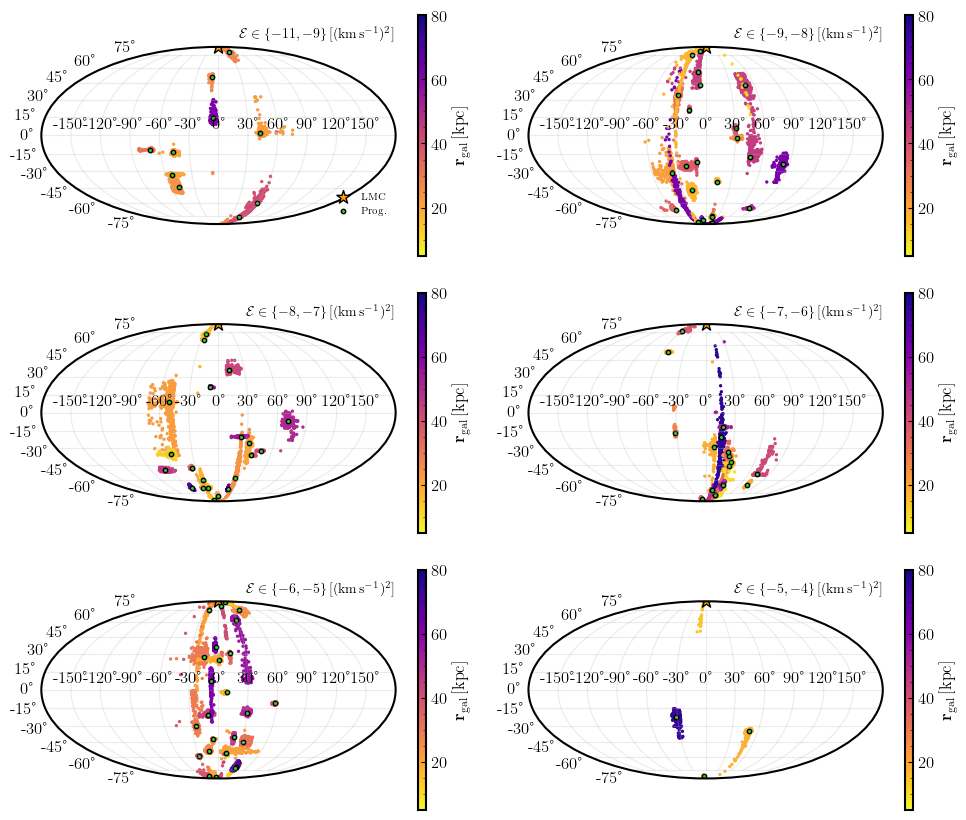

In [46]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
pot = 'Full-MWhalo-MWdisc-LMC.hdf5'
# pot = 'full-MWhalo-full-MWdisc-no-LMC.hdf5'
# pot = 'static-mw.hdf5'
# pot = 'rigid-mw.hdf5'

mollweide_poles_Ebins(path, pot, 'LMC', 'poles-rigid-mw-no-motion', False)

Coloured by quantities

In [70]:
def median_mollweide_poles_Ebins(data_path, potential, frame, cbar, plotname, savefig=False):
    
    labels = list([r'$\mathcal{E} \in \{-11, -9\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-9, -8\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-8, -7\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-7, -6\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-6, -5\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-5, -4\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$'])
   
    with h5py.File(data_path + potential,'r') as file:
        
        energies = np.array(file['energies'])
        loc_veldis = np.array(file['loc_veldis'])
        widths = np.array(file['widths'])
        track_deform = np.array(file['track_deform'])

        t_idx = -1
        l_pole = np.array(file['pole_l'])[:,t_idx]
        b_pole = np.array(file['pole_b'])[:,t_idx]
        med_l_pole = np.nanmedian(l_pole, axis=1)
        med_b_pole = np.nanmedian(b_pole, axis=1)
        
    E_bins = np.delete(np.linspace(-11,-4,8), 1)
    hist, bins = np.histogram(energies/1e4, E_bins)

    # Initialize a list to store indices
    indices_in_bins = []
    for i in range(len(bins) - 1):
        # Select indices of data points that fall within the current bin
        indices = np.where((energies/1e4 >= bins[i]) & (energies/1e4 < bins[i+1]))[0]
        indices_in_bins.append(indices)
        
    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
    fig, ax = plt.subplots(3, 2, subplot_kw={'projection': 'mollweide'}, figsize=(12, 12))
    plt.subplots_adjust(hspace=-0.25, wspace=0.1)

    j = 0
    for idx in indices_in_bins:
        
        plt.sca(ax[pltidx[j]])
        ax[pltidx[j]].tick_params(labelsize=8)
        plt.grid(alpha=.25)

        if frame=='LMC':
            med_poles =  np.stack((med_l_pole, med_b_pole))
            poles =  np.stack((l_pole, b_pole))
            
            med_rot_pole = np.array([rotation_matrix_lmc @ med_poles[:,i] for i in range(len(med_l_pole))])
            rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
            
            l_pole_std, b_pole_std = np.nanstd(rot_pole[:,0],axis=1), np.nanstd(rot_pole[:,1],axis=1)
            
            plt.scatter(0, (90*u.deg).to(u.rad), s=200,
                     edgecolors='k', facecolor='lightblue',marker='*', label='LMC', rasterized=True)
            
        if frame =='disc':
            med_poles =  np.stack((med_l_pole, med_b_pole))
            poles =  np.stack((l_pole, b_pole))
            
            med_rot_pole = np.array([rotation_matrix_lmc @ med_poles[:,i] for i in range(len(med_l_pole))])
            rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
            
            l_pole_std, b_pole_std = np.nanstd(rot_pole[:,0],axis=1), np.nanstd(rot_pole[:,1],axis=1)
            
            plt.scatter(0, (90*u.deg).to(u.rad), s=200,
                    edgecolors='k', facecolor='r',marker='o', label='Disc', rasterized=True)

        l_poles = med_rot_pole[:,0]*u.deg 
        l_poles_i = np.where(l_poles.value>=180, l_poles.value - 360, l_poles.value)
        l_poles = np.where(l_poles_i<=-180, l_poles_i + 360, l_poles_i)

        b_poles = med_rot_pole[:,1]*u.deg 
        b_poles = np.where(b_poles.value>=90, b_poles.value - 180, b_poles.value)
        
        if cbar=='veldis':

            sc=plt.scatter((l_poles[idx])*u.deg.to(u.rad), (b_poles[idx])*u.deg.to(u.rad), 
                            c=loc_veldis[idx], cmap='YlOrRd',vmin=0, vmax=20, s=5, rasterized=True)
            
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\sigma_{v, \mathrm{loc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
            cb.ax.tick_params(labelsize=12)
    
        elif cbar=='deviation':

            sc=plt.scatter((l_poles[idx])*u.deg.to(u.rad), (b_poles[idx])*u.deg.to(u.rad), 
                            c=track_deform[idx], cmap='YlOrRd', vmin=0, vmax=10, s=5, rasterized=True)
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\bar{\delta}\,[^{\circ}]$')
            cb.ax.tick_params(labelsize=12)
            
        elif cbar=='widths':

            sc=plt.scatter((l_poles[idx])*u.deg.to(u.rad), (b_poles[idx])*u.deg.to(u.rad), 
                            c=widths[idx], cmap='YlOrRd', vmin=0, vmax=3, s=5, rasterized=True)
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$w\,[^{\circ}]$')
            cb.ax.tick_params(labelsize=12)
            
        elif cbar=='lon_pole':

            sc=plt.scatter((l_poles[idx])*u.deg.to(u.rad), (b_poles[idx])*u.deg.to(u.rad), 
                            c=l_pole_std[idx], cmap='YlOrRd', vmin=0, vmax=10, s=5, rasterized=True)
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\sigma_{l,\mathrm{pole}}\,[^{\circ}]$')
            cb.ax.tick_params(labelsize=12)
            
        elif cbar=='lat_pole':

            sc=plt.scatter((l_poles[idx])*u.deg.to(u.rad), (b_poles[idx])*u.deg.to(u.rad), 
                            c=b_pole_std[idx], cmap='YlOrRd', norm=LogNorm(vmin=0.1, vmax=100), s=5, rasterized=True)
            cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
            cb.set_label(r'$\sigma_{b,\mathrm{pole}}\,[^{\circ}]$')
            cb.ax.tick_params(labelsize=10) 
            
        ax[pltidx[j]].set_title(labels[j], fontsize=10, loc='right')

        if j ==0:
            plt.legend(frameon=False, fontsize=7, loc='lower right')
        j += 1
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))
    # plt.close()

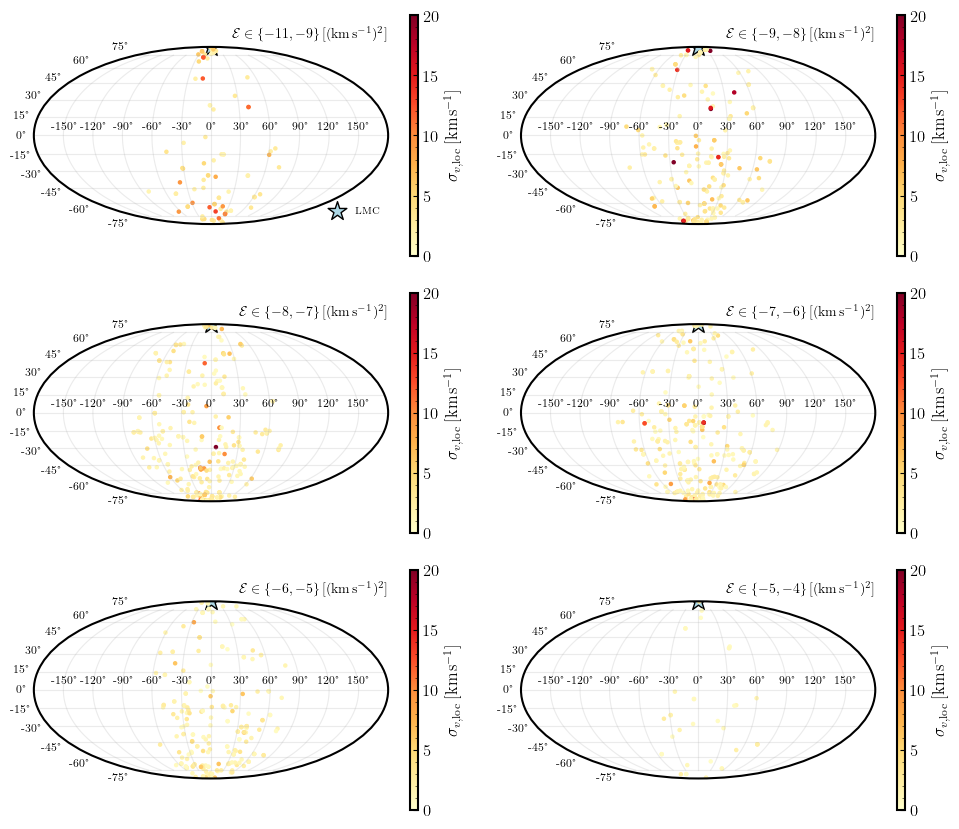

In [76]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
pot = 'Full-MWhalo-MWdisc-LMC.hdf5'

median_mollweide_poles_Ebins(path, pot, 'LMC', 'veldis', 'pole-ebins-veldis-fullexp', True)

### Mollweide projection of Galactic Coordinates (median of stream)

In [26]:
def galactic_coords(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    # positions = p + Model.expansion_centres(0.)[:3]
    # velocities = v + Model.expansion_centre_velocities(0.)[:3]
    
    posvel_gc = SkyCoord(x=p[:,0]*u.kpc, y=p[:,1]*u.kpc, z=p[:,2]*u.kpc,
                         v_x=v[:,0]*u.km/u.s, v_y=v[:,1]*u.km/u.s, v_z=v[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    l, b, d = np.nanmedian(posvel_galactic_rc.l), np.nanmedian(posvel_galactic_rc.b), np.nanmedian(posvel_galactic_rc.distance)
    pm_l_cosb, pm_b, rvs = np.nanmedian(posvel_galactic_rc.pm_l_cosb), np.nanmedian(posvel_galactic_rc.pm_b), np.nanmedian(posvel_galactic_rc.radial_velocity)
    
    sigma_rv = np.nanstd(posvel_galactic_rc.radial_velocity)
    
    return l.value, b.value, d.value, pm_l_cosb.value, pm_b.value, rvs.value, sigma_rv.value

In [31]:
def mollewide_gc(path_data, pots, pot_labels, plotname, savefig=False):

    lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
    lmc_l_gc, lmc_b_gc, *_ = galactic_coords(np.array(lmc_xs)[:, None].T, np.array(lmc_vs)[:, None].T)

    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]

    fig, ax = plt.subplots(4, 2, subplot_kw={'projection': 'mollweide'}, figsize=(14, 16))

    plt.subplots_adjust(hspace=-0.1, wspace=0.1)

    for j in range(len(pots)): 

        with h5py.File(path + potentials[j],'r') as file:
            
            t_idx = -1

            l_gc = np.array(file['l_gc'])
            b_gc = np.array(file['b_gc'])
            ds = np.array(file['ds'])
            loc_veldis = np.array(file['loc_veldis'])
      
        rng = np.random.default_rng(seed=1)

        # sample_ls = (l_gc*u.deg - 180*u.deg)
        wrapped_ls = np.where(l_gc>=180, l_gc - 360, l_gc)
        plt.sca(ax[pltidx[j]])
        plt.grid(alpha=.25)
        rng = np.random.default_rng(seed=1)
 
        
        sc=plt.scatter(wrapped_ls*u.deg.to(u.rad), b_gc*u.deg.to(u.rad), c=loc_veldis, cmap='Greys', s=5,rasterized=True, vmin=0,vmax=20)
        lmc_l_gc_wrap = np.where(lmc_l_gc>=180, lmc_l_gc-360, lmc_l_gc)
        plt.scatter(lmc_l_gc_wrap*u.deg.to(u.rad), lmc_b_gc*u.deg.to(u.rad), s=150,
                        edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)


        cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
        cb.set_label(r'Velocity dispersion [km/s]')
        cb.ax.tick_params(labelsize=12)

        plt.title(labels[j], loc='left', fontsize=10)
        if j ==0:
            plt.legend(frameon=False, fontsize=7, loc='upper right')
            
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/{}'.format(plotname))
    # plt.close()

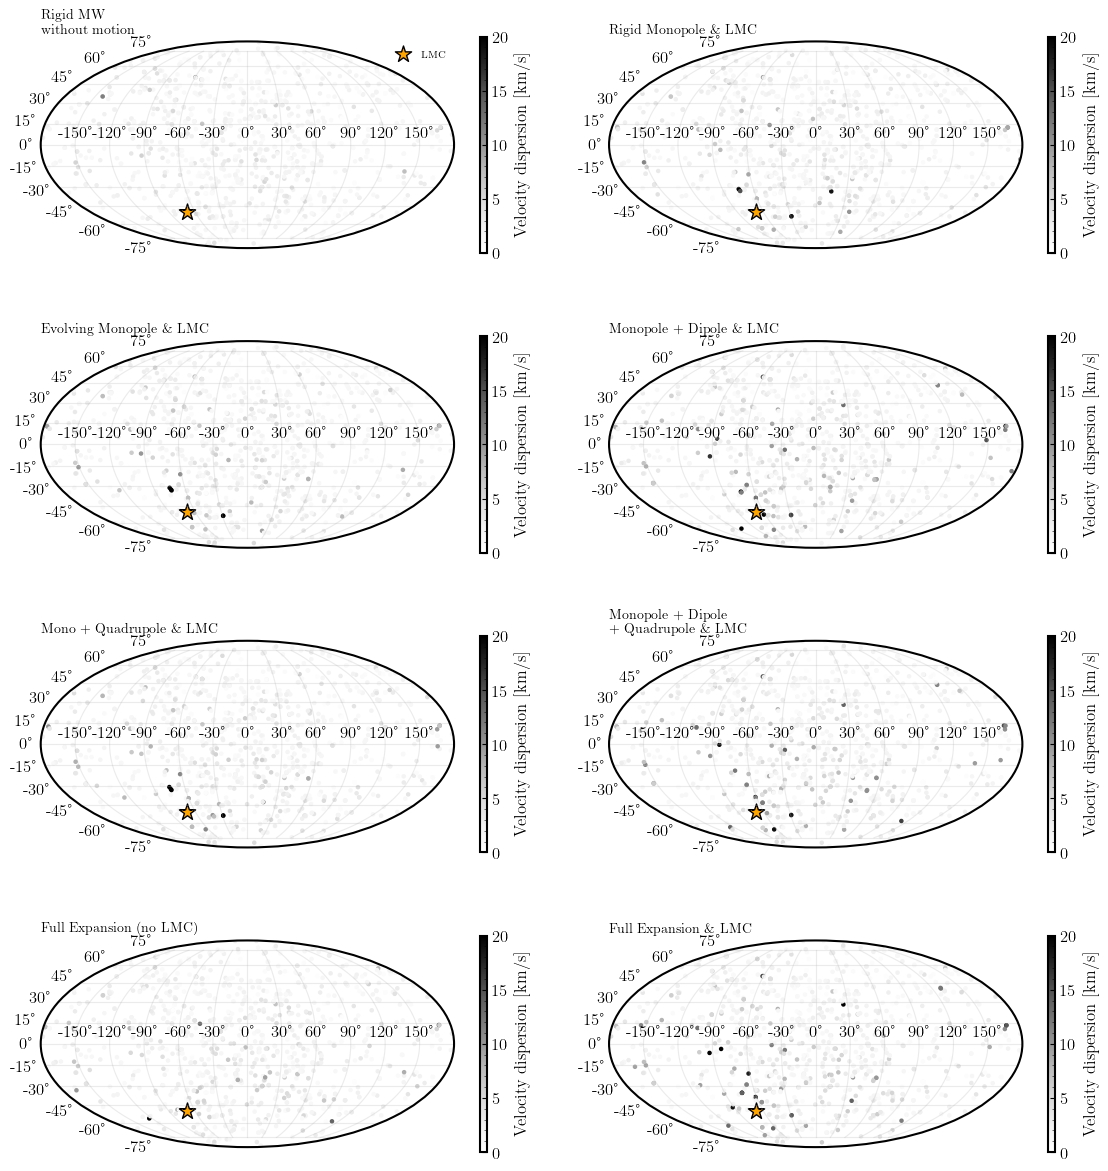

In [33]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'

potentials = list(['rigid-mw.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                        'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5',])

labels = list(['Rigid MW \n without motion','Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', 'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', \
               'Monopole + Dipole \n + Quadrupole \& LMC',  'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

mollewide_gc(path, potentials, labels, 'mollweide_gc_veldis', True)

Bins in energy

In [45]:
def mollweide_gc_Ebins(data_path, potential, plotname, savefig=False):
    
    labels = list([r'$\mathcal{E} \in \{-11, -9\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-9, -8\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-8, -7\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-7, -6\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', 
             r'$\mathcal{E} \in \{-6, -5\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$',
             r'$\mathcal{E} \in \{-5, -4\}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$'])
   
    with h5py.File(data_path + potential,'r') as file:

        energies = np.array(file['energies'])
        l_gc = np.array(file['l_gc'])
        b_gc = np.array(file['b_gc'])
        ds = np.array(file['ds'])
        loc_veldis = np.array(file['loc_veldis'])
        track_deform = np.array(file['track_deform'])
        
    E_bins = np.delete(np.linspace(-11,-4,8), 1)
    hist, bins = np.histogram(energies/1e4, E_bins)

    # Initialize a list to store indices
    indices_in_bins = []
    for i in range(len(bins) - 1):
        # Select indices of data points that fall within the current bin
        indices = np.where((energies/1e4 >= bins[i]) & (energies/1e4 < bins[i+1]))[0]
        indices_in_bins.append(indices)
        
        
    pltidx = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

    lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
    lmc_l_gc, lmc_b_gc, *_ = galactic_coords(np.array(lmc_xs)[:, None].T, np.array(lmc_vs)[:, None].T)
    lmc_l_gc_wrap = np.where(lmc_l_gc>=180, lmc_l_gc-360, lmc_l_gc)
    
    fig, ax = plt.subplots(3, 2, subplot_kw={'projection': 'mollweide'}, figsize=(12, 12))
    plt.subplots_adjust(hspace=-0.25, wspace=0.1)

    j = 0
    for idx in indices_in_bins:

        ls_bin = l_gc[idx]
        bs_bin = b_gc[idx]
        veldis_bin = loc_veldis[idx]
        trackdeform_bin = track_deform[idx]

        # sample_ls = (ls_bin*u.deg - 180*u.deg)
        # wrapped_ls = np.where(sample_ls.value<=-180, sample_ls.value + 360, sample_ls.value)
        # sample_ls = (l_gc*u.deg - 180*u.deg)
        wrapped_ls = np.where(ls_bin>=180, ls_bin - 360, ls_bin)

        plt.sca(ax[pltidx[j]])
        plt.grid(alpha=.25)

        # sc=plt.scatter(wrapped_ls*u.deg.to(u.rad), bs_bin*u.deg.to(u.rad), c=veldis_bin, cmap='Greys', s=5,rasterized=True, vmin=0,vmax=20)
        sc=plt.scatter(wrapped_ls*u.deg.to(u.rad), bs_bin*u.deg.to(u.rad), c=trackdeform_bin, cmap='Greys', s=5,rasterized=True, vmin=0, vmax=10)

        plt.scatter(lmc_l_gc_wrap*u.deg.to(u.rad), lmc_b_gc*u.deg.to(u.rad), s=75,
                            edgecolors='k', facecolor='orange',marker='*', label='LMC', rasterized=True)


        cb=plt.colorbar(sc,location='right', aspect=30, pad=0.05, shrink=.65)
        # cb.set_label(r'$\sigma_{v, \mathrm{loc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
        cb.set_label(r'$\bar{\delta}\,[^{\circ}]$')
        cb.ax.tick_params(labelsize=10)

        ax[pltidx[j]].set_xticks([-np.pi,-3*np.pi/4,-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4,np.pi], 
                  labels=[r'$0\,^{\circ}$','','','','','', '','',r'$360\,^{\circ}$',], fontsize=8)
        ax[pltidx[j]].set_yticks([-np.pi/2, -np.pi/4, -np.pi/8, 0, np.pi/8,np.pi/4, np.pi/2],
                 labels=[r'$-90\,^{\circ}$', '', '','','','', r'$90\,^{\circ}$',], fontsize=8)
        ax[pltidx[j]].set_title(labels[j], fontsize=10, loc='right')
        j += 1
        
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))
    # plt.close()

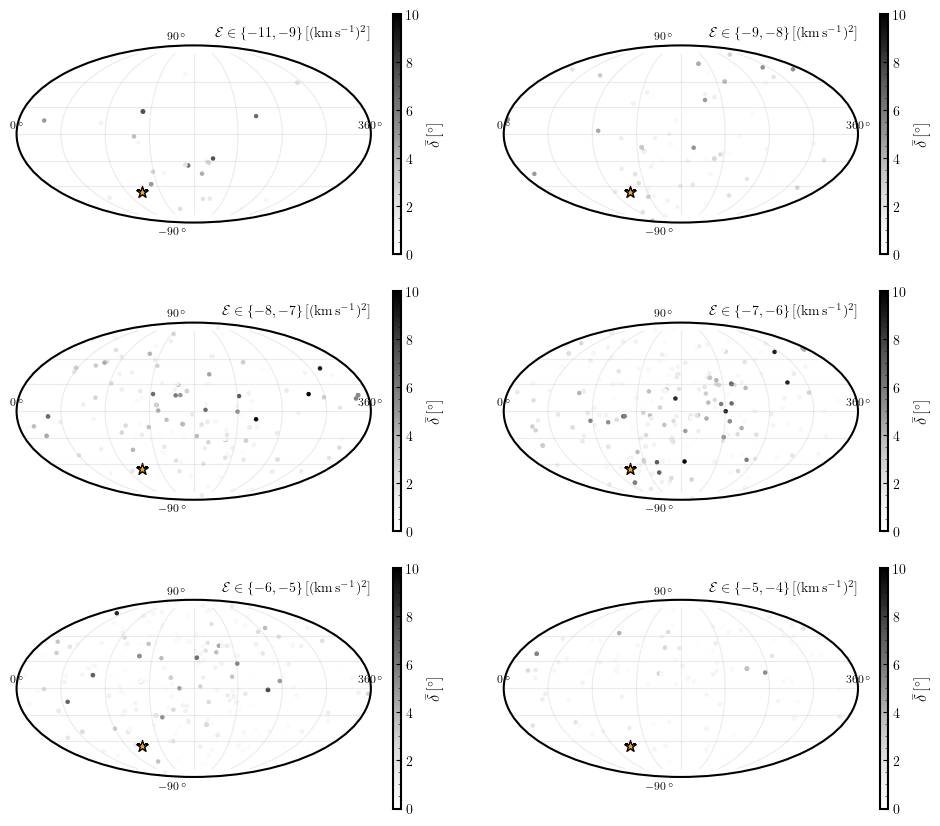

In [49]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
# pot = 'Full-MWhalo-MWdisc-LMC.hdf5'
pot = 'full-MWhalo-full-MWdisc-no-LMC.hdf5'
# pot = 'static-mw.hdf5'
# pot = 'rigid-mw.hdf5'

mollweide_gc_Ebins(path, pot, 'gc-full-mwh-full-mwh-no-lmc', False)

### Fraction of streams satisfying threshold cuts on 'stream summary statistics'

In [5]:
def frac_streams_indiv(path_data, quantity, pots, pot_labels, plotname, savefig=False):

    fig, ax = plt.subplots(1,1, figsize=(5, 3))

    for j in range(len(pots)): 

        with h5py.File(path + pots[j],'r') as file:
            
            energies = np.array(file['energies'])
            if quantity=='veldis':
                loc_veldis = np.array(file['loc_veldis'])
    
            elif quantity=='width':
                widths = np.array(file['widths'])
                
            elif quantity=='deviation':
                track_deform = np.array(file['track_deform'])
                
            elif quantity=='lon_pole':
                t_idx = -1
                l_pole = np.array(file['pole_l'])[:,t_idx]
                l_pole_std = np.nanstd(l_pole, axis=1)
                
            elif quantity=='lat_pole':
                t_idx = -1
                b_pole = np.array(file['pole_b'])[:,t_idx]
                b_pole_std = np.nanstd(b_pole, axis=1)
        
        E_bins = np.delete(np.linspace(-11,-4,8), 1)
        hist, bins = np.histogram(energies/1e4, E_bins)

        indices_in_bins = []
        for i in range(len(bins) - 1):
            indices = np.where((energies/1e4 >= bins[i]) & (energies/1e4 < bins[i+1]))[0]
            indices_in_bins.append(indices)
        
        plt.sca(ax)
        frac = []
        uncert = []
        if quantity=='veldis':
            for idx in indices_in_bins:
                veldis_bin = loc_veldis[idx]
                if len(veldis_bin)==0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(veldis_bin[veldis_bin < 2.5])
                    total = len(veldis_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_v > 2.5\,\mathrm{km}\,\mathrm{s}^{-1} \right)$', fontsize=12)
                
        elif quantity=='width':
            for idx in indices_in_bins:
                widths_bin = widths[idx]
                if len(widths_bin)==0:
                    frac_highvel = 1
                    uncert_high = 0
                else:
                    above = len(widths_bin[widths_bin < .5])
                    total = len(widths_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,w < 0.5^{\circ} \right)$', fontsize=12)
            
        elif quantity=='deviation':
            for idx in indices_in_bins:
                track_deform_bin = track_deform[idx]
                if len(track_deform_bin)==0:
                    frac_highvel = 1
                    uncert_high = 0
                else:
                    above = len(track_deform_bin[track_deform_bin < 1])
                    total = len(track_deform_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\bar{\delta} < 1^{\circ} \right)$', fontsize=12)
                
        elif quantity=='lon_pole':
            for idx in indices_in_bins:
                lpole_std_bin = l_pole_std[idx]
                if len(lpole_std_bin)==0:
                    frac_highvel = 1
                    uncert_high = 0
                else:
                    above = len(lpole_std_bin[lpole_std_bin < 2])
                    total = len(lpole_std_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_{l,\mathrm{pole}} < 2^{\circ} \right)$', fontsize=12)
                
        elif quantity=='lat_pole':
            for idx in indices_in_bins:
                bpole_std_bin = b_pole_std[idx]
                if len(bpole_std_bin)==0:
                    frac_highvel = 1
                    uncert_high = 0
                else:
                    above = len(bpole_std_bin[bpole_std_bin < 2])
                    total = len(bpole_std_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            plt.ylabel(r'$f\left(E\,;\,\sigma_{b,\mathrm{pole}} < 2^{\circ} \right)$', fontsize=12)
                
        bin_mids = [(E_bins[i] + E_bins[i+1])/2 for i in range(len(E_bins) - 1)]

        if j==(len(pots)-1):
            plt.plot(bin_mids, frac, c='k', lw=2.5, label=labels[j], zorder=1)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.3, edgecolor='None')
        elif j==(len(pots)-2):
            plt.plot(bin_mids, frac, c='k', lw=2, ls='dashed', label=labels[j])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             color='k', alpha=0.1, edgecolor='None')
        else:    
            plt.plot(bin_mids, frac, lw=1, label=labels[j], zorder=2)
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                             alpha=0.1, edgecolor='None')
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)

    plt.legend(frameon=False, ncol=1, bbox_to_anchor=(1.0,1.0), fontsize=12)
    plt.xlim(-9.99,-4.51)
    plt.ylim(0.01, 1.02)
    
    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))
    # plt.close()

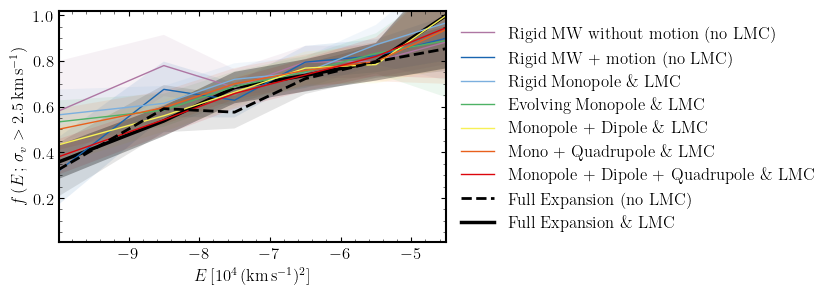

In [6]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
               'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
       'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

frac_streams_indiv(path, 'veldis', potentials, labels, 'frac_streams_veldis', False)
# frac_streams_indiv(path, 'width', potentials, labels, 'frac_streams_width', False)
# frac_streams_indiv(path, 'deviation', potentials, labels, 'frac_streams_deviation', False)
# frac_streams_indiv(path, 'lon_pole', potentials, labels, 'frac_streams_lonpole', False)
# frac_streams_indiv(path, 'lat_pole', potentials, labels, 'frac_streams_latpole', False)

In [7]:
def frac_streams_all(path_data, pots, pot_labels, plotname, savefig=False):
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for j in range(len(pots)):
        with h5py.File(path_data + pots[j], 'r') as file:
            energies = np.array(file['energies'])
            loc_veldis = np.array(file['loc_veldis'])
            widths = np.array(file['widths'])
            track_deform = np.array(file['track_deform'])

            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            # l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            # b_pole_std = np.nanstd(b_pole, axis=1)
        
            poles =  np.stack((l_pole, b_pole))
        rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
        l_pole_std, b_pole_std = np.nanstd(rot_pole[:,0],axis=1), np.nanstd(rot_pole[:,1],axis=1)

        E_bins = np.delete(np.linspace(-11, -4, 8), 1)
        hist, bins = np.histogram(energies / 1e4, E_bins)

        bin_mids = [(E_bins[i] + E_bins[i + 1]) / 2 for i in range(len(E_bins) - 1)]
        indices_in_bins = [np.where((energies / 1e4 >= bins[i]) & (energies / 1e4 < bins[i + 1]))[0] for i in range(len(bins) - 1)]

        def plot_metric(ax, metric, threshold, y_label, title):
            frac = []
            uncert = []
            for idx in indices_in_bins:
                metric_bin = metric[idx]
                if len(metric_bin) == 0:
                    frac_high = 1
                    uncert_high = 0
                else:
                    above = len(metric_bin[metric_bin < threshold])
                    total = len(metric_bin)
                    frac_high = above / total
                    uncert_high = frac_high * ((1 / above) + (1 / total))**0.5
                frac.append(frac_high)
                uncert.append(uncert_high)
            if j == (len(pots) - 1):
                plt.plot(bin_mids, frac, c='k', lw=2.5, label=pot_labels[j], zorder=1)
                plt.fill_between(bin_mids, np.array(frac) - np.array(uncert), np.array(frac) + np.array(uncert),
                                 color='k', alpha=0.3, edgecolor='None')
            elif j == (len(pots) - 2):
                plt.plot(bin_mids, frac, c='k', lw=2, ls='dashed', label=pot_labels[j])
                plt.fill_between(bin_mids, np.array(frac) - np.array(uncert), np.array(frac) + np.array(uncert),
                                 color='k', alpha=0.2, edgecolor='None')
            else:
                plt.plot(bin_mids, frac, lw=1, label=pot_labels[j], zorder=2)
                plt.fill_between(bin_mids, np.array(frac) - np.array(uncert), np.array(frac) + np.array(uncert),
                                 alpha=0.2, edgecolor='None')
            plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
            plt.ylabel(y_label, fontsize=12)
            plt.xlim(-9.99, -4.51)
            plt.ylim(0.01, 1.02)
            plt.title(title)

        plt.sca(ax[0, 0])
        plot_metric(ax[0, 0], loc_veldis, 2.5, r'$f\left(E\,;\,\sigma_v < 2.5\,\mathrm{km}\,\mathrm{s}^{-1} \right)$', 'Local velocity dispersion')

        plt.sca(ax[0, 1])
        plot_metric(ax[0, 1], widths, 0.5, r'$f\left(E\,;\,w < 0.5^{\circ} \right)$', 'Width')

        plt.sca(ax[1, 0])
        plot_metric(ax[1, 0], track_deform, 1, r'$f\left(E\,;\,\bar{\delta} < 1^{\circ} \right)$', 'Deviation from Great Circle')

        plt.sca(ax[1, 1])
        plot_metric(ax[1, 1], l_pole_std, 2, r'$f\left(E\,;\,\sigma_{l^{\prime},\,\mathrm{pole}} < 2^{\circ} \right)$', 'Longitudinal pole spread')

        plt.sca(ax[2, 0])
        plot_metric(ax[2, 0], b_pole_std, 2, r'$f\left(E\,;\,\sigma_{b^{\prime},\,\mathrm{pole}} < 2^{\circ} \right)$', 'Latitudinal pole spread')

        plt.legend(frameon=False, ncol=1, bbox_to_anchor=(1.2, 1.05), fontsize=12)

    ax[2, 1].set_visible(False)

    if savefig:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))


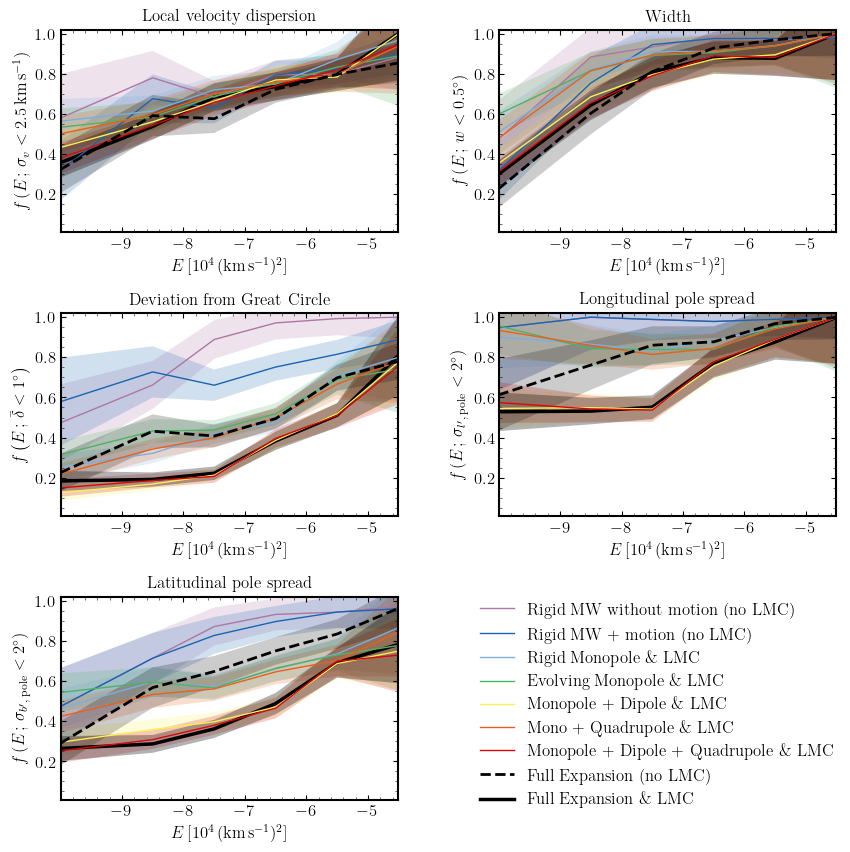

In [8]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
               'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])
# potentials = list(['rigid-mw.hdf5'])

labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
       'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])
# labels = list(['Rigid MW without motion (no LMC)'])

frac_streams_all(path, potentials, labels, 'frac_streams_combined', True)

Splitting these results into quadrants on sky to investigate what the LMC has done

In [11]:
def galactic_coords(p, v):
    
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    posvel_gc = SkyCoord(x=p[:,0]*u.kpc, y=p[:,1]*u.kpc, z=p[:,2]*u.kpc,
                         v_x=v[:,0]*u.km/u.s, v_y=v[:,1]*u.km/u.s, v_z=v[:,2]*u.km/u.s ,
                         frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b, posvel_galactic_rc.distance
    pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity
    
    return l.value, b.value, d.value, pm_l_cosb.value, pm_b.value, rvs.value,

In [12]:
ts=np.linspace(-5, 0, 1000)
lmc_xs = [Model.expansion_centres(t)[6:9] for t in ts]
lmc_vs =  [Model.expansion_centre_velocities(t)[6:9] for t in ts]
lmc_l_gc, lmc_b_gc, *_ = galactic_coords(np.array(lmc_xs), np.array(lmc_vs))

disc_xs = [Model.expansion_centres(t)[:3] for t in ts]
lmc_dist_gc = np.linalg.norm(np.array(lmc_xs) - np.array(disc_xs), axis=1)

In [20]:
def frac_streams_all_QUAD(path_data, potl, pot_name, labels, plotname, savefig=False):

    fig, ax = plt.subplots(3,2, figsize=(10, 10))
    mollweide_ax = fig.add_subplot(3, 2, 6, projection='mollweide')
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    print("Reading data...")
    with h5py.File(path + potl,'r') as file:

        energies = np.array(file['energies'])
        loc_veldis = np.array(file['loc_veldis'])
        widths = np.array(file['widths'])
        track_deform = np.array(file['track_deform'])

        t_idx = -1
        l_pole = np.array(file['pole_l'])[:,t_idx]
        b_pole = np.array(file['pole_b'])[:,t_idx]
        
        l_gc = np.array(file['l_gc'])
        b_gc = np.array(file['b_gc'])

        poles =  np.stack((l_pole, b_pole))
    print("Data read...")    
    rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
    l_pole_std, b_pole_std = np.nanstd(rot_pole[:,0],axis=1), np.nanstd(rot_pole[:,1],axis=1)
    
    wrapped_l_gc = np.where(l_gc>=180, l_gc - 360, l_gc)
            
    mask_q1 = ( (wrapped_l_gc > -180) & (wrapped_l_gc < 0) & (b_gc > 0) & (b_gc < 90) )
    mask_q2 = ( (wrapped_l_gc > 0) & (wrapped_l_gc < 180) & (b_gc > 0) & (b_gc < 90) )
    mask_q3 = ( (wrapped_l_gc > -180) & (wrapped_l_gc < 0) & (b_gc > -90) & (b_gc < 0) )
    mask_q4 = ( (wrapped_l_gc > 0) & (wrapped_l_gc < 180) & (b_gc > -90) & (b_gc < 0) )
    masks = [mask_q1, mask_q2, mask_q3, mask_q4]

    E_bins = np.delete(np.linspace(-11,-4,8), 1)
    bin_mids = [(E_bins[i] + E_bins[i+1])/2 for i in range(len(E_bins) - 1)]

    # Define the colors for each quadrant
    colors = ['#EE7733', '#009988', '#33BBEE', '#EE3377'] 
    
    plt.suptitle(pot_name, y=0.94, fontweight='bold')
    
    for m in range(len(masks)):
        print("Plotting Q{}".format(m+1))
        Es = energies[masks[m]]
        hist, bins = np.histogram(Es/1e4, E_bins)

        indices_in_bins = []
        for i in range(len(bins) - 1):
            indices = np.where((Es/1e4 > bins[i]) & (Es/1e4 < bins[i+1]))[0]
            indices_in_bins.append(indices)

        plt.sca(ax[0,0])
        frac = []
        uncert = []
        for idx in indices_in_bins:
            veldis_bin = loc_veldis[masks[m]][idx]
            if len(veldis_bin)==0:
                frac_high = 1
                uncert_high = 0
            else:
                above = len(veldis_bin[veldis_bin < 2.5])
                total = len(veldis_bin)
                if above==0:
                    frac_high, uncert_high =0, 0
                else:
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)

        if m==2 or m==3:
            plt.plot(bin_mids, frac, lw=3, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.3, edgecolor='None', color=colors[m])
        else:
            plt.plot(bin_mids, frac, lw=1, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.1, edgecolor='None', color=colors[m])

        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        plt.ylabel(r'$f\left(E\,;\,\sigma_v < 2.5\,\mathrm{km}\,\mathrm{s}^{-1} \right)$', fontsize=12)
        plt.xlim(-9.99,-4.51)
        plt.ylim(0.01, 1.02)
        plt.title('Local velocity dispersion')

        plt.sca(ax[0,1])
        frac = []
        uncert = []
        for idx in indices_in_bins:
            widths_bin = widths[masks[m]][idx]
            if len(widths_bin)==0:
                frac_highvel = 1
                uncert_high = 0
            else:
                above = len(widths_bin[widths_bin < .5])
                total = len(widths_bin)
                if above==0:
                    frac_high, uncert_high =0, 0
                else:
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)
        if m==2 or m==3:
            plt.plot(bin_mids, frac, lw=3, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.3, edgecolor='None', color=colors[m])
        else:
            plt.plot(bin_mids, frac, lw=1, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.1, edgecolor='None', color=colors[m])
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        plt.ylabel(r'$f\left(E\,;\,w < 0.5^{\circ} \right)$', fontsize=12)
        plt.xlim(-9.99,-4.51)
        plt.ylim(0.01, 1.02)
        plt.title('Width')

        plt.sca(ax[1,0])
        frac = []
        uncert = []
        for idx in indices_in_bins:
            track_deform_bin = track_deform[masks[m]][idx]
            if len(track_deform_bin)==0:
                frac_highvel = 1
                uncert_high = 0
            else:
                above = len(track_deform_bin[track_deform_bin < 1])
                total = len(track_deform_bin)
                if above==0:
                    frac_high, uncert_high =0, 0
                else:
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)
        if m==2 or m==3:
            plt.plot(bin_mids, frac, lw=3, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.3, edgecolor='None', color=colors[m])
        else:
            plt.plot(bin_mids, frac, lw=1, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.1, edgecolor='None', color=colors[m])
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        plt.ylabel(r'$f\left(E\,;\,\bar{\delta} < 1^{\circ} \right)$', fontsize=12)
        plt.xlim(-9.99,-4.51)
        plt.ylim(0.01, 1.02)
        plt.title('Deviation from Great Circle')

        plt.sca(ax[1,1])
        frac = []
        uncert = []
        for idx in indices_in_bins:
            lpole_std_bin = l_pole_std[masks[m]][idx]
            if len(lpole_std_bin)==0:
                frac_highvel = 1
                uncert_high = 0
            else:
                above = len(lpole_std_bin[lpole_std_bin < 2])
                total = len(lpole_std_bin)
                if above==0:
                    frac_high, uncert_high =0, 0
                else:
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)
        if m==2 or m==3:
            plt.plot(bin_mids, frac, lw=3, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.3, edgecolor='None', color=colors[m])
        else:
            plt.plot(bin_mids, frac, lw=1, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.1, edgecolor='None', color=colors[m])
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        plt.ylabel(r'$f\left(E\,;\,\sigma_{l^{\prime},\,\mathrm{pole}} < 2^{\circ} \right)$', fontsize=12)
        plt.xlim(-9.99,-4.51)
        plt.ylim(0.01, 1.02)
        plt.title('Longitudinal pole spread')

        plt.sca(ax[2,0])
        frac = []
        uncert = []
        for idx in indices_in_bins:
            bpole_std_bin = b_pole_std[masks[m]][idx]
            if len(bpole_std_bin)==0:
                frac_highvel = 1
                uncert_high = 0
            else:
                above = len(bpole_std_bin[bpole_std_bin < 2])
                total = len(bpole_std_bin)
                if above==0:
                    frac_high, uncert_high =0, 0
                else:
                    frac_high = above / total
                    uncert_high = frac_high * ((1/above) + (1/total))**0.5
            frac.append(frac_high)
            uncert.append(uncert_high)
        if m==2 or m==3:
            plt.plot(bin_mids, frac, lw=3, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.3, edgecolor='None', color=colors[m])
        else:
            plt.plot(bin_mids, frac, lw=1, label=labels[m], c=colors[m])
            plt.fill_between(bin_mids, np.array(frac)-np.array(uncert), np.array(frac)+np.array(uncert),
                         alpha=0.1, edgecolor='None', color=colors[m])
        plt.xlabel(r'$E\,[10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=12)
        plt.ylabel(r'$f\left(E\,;\,\sigma_{b^{\prime},\,\mathrm{pole}} < 2^{\circ} \right)$', fontsize=12)
        plt.xlim(-9.99,-4.51)
        plt.ylim(0.01, 1.02)
        plt.title('Latitudinal pole spread')

        plt.legend(frameon=False, ncol=1, fontsize=10)
                
    ax[2,1].set_visible(False)
    plt.sca(mollweide_ax)
    plt.grid(alpha=.25)    

    # Define the vertices for the quadrants
    quadrants = [
        Polygon([[-np.pi, 0], [0, 0], [0, np.pi/2], [-np.pi, np.pi/2]], closed=True),  # Top-left
        Polygon([[0, 0], [np.pi, 0], [np.pi, np.pi/2], [0, np.pi/2]], closed=True),    # Top-right
        Polygon([[-np.pi, -np.pi/2], [0, -np.pi/2], [0, 0], [-np.pi, 0]], closed=True),  # Bottom-left
        Polygon([[0, -np.pi/2], [np.pi, -np.pi/2], [np.pi, 0], [0, 0]], closed=True),    # Bottom-right
    ]

    # Fill each quadrant with the respective color
    for color, quad in zip(colors, quadrants):
        mollweide_ax.add_patch(quad)
        quad.set_facecolor(color)
        quad.set_alpha(0.2)

    lmc_l_gc_wrap = np.where(lmc_l_gc>=180, lmc_l_gc-360, lmc_l_gc)
    plt.scatter((lmc_l_gc_wrap[-1])*u.deg.to(u.rad), lmc_b_gc[-1]*u.deg.to(u.rad), s=100,
                            edgecolors='k', facecolor='orange',marker='*', rasterized=True, zorder=2)
    sc=plt.scatter((lmc_l_gc_wrap)*u.deg.to(u.rad), lmc_b_gc*u.deg.to(u.rad), rasterized=True,
                   s=5, c=lmc_dist_gc, cmap='Greys_r', norm=LogNorm(vmin=45, vmax=750), zorder=1)
    cb=plt.colorbar(sc,location='bottom', aspect=30, pad=0.1, shrink=.6)
    cb.set_label(r'$\mathbf{r}_{\mathrm{LMC}}\,[\mathrm{kpc}]$')
    cb.ax.tick_params(labelsize=10)
    
    mollweide_ax.tick_params( labelsize=8)

    if savefig==True:
        plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/mollweide/ebins/{}'.format(plotname))
    # plt.close()

Reading data...
Data read...
Plotting Q1
Plotting Q2
Plotting Q3
Plotting Q4


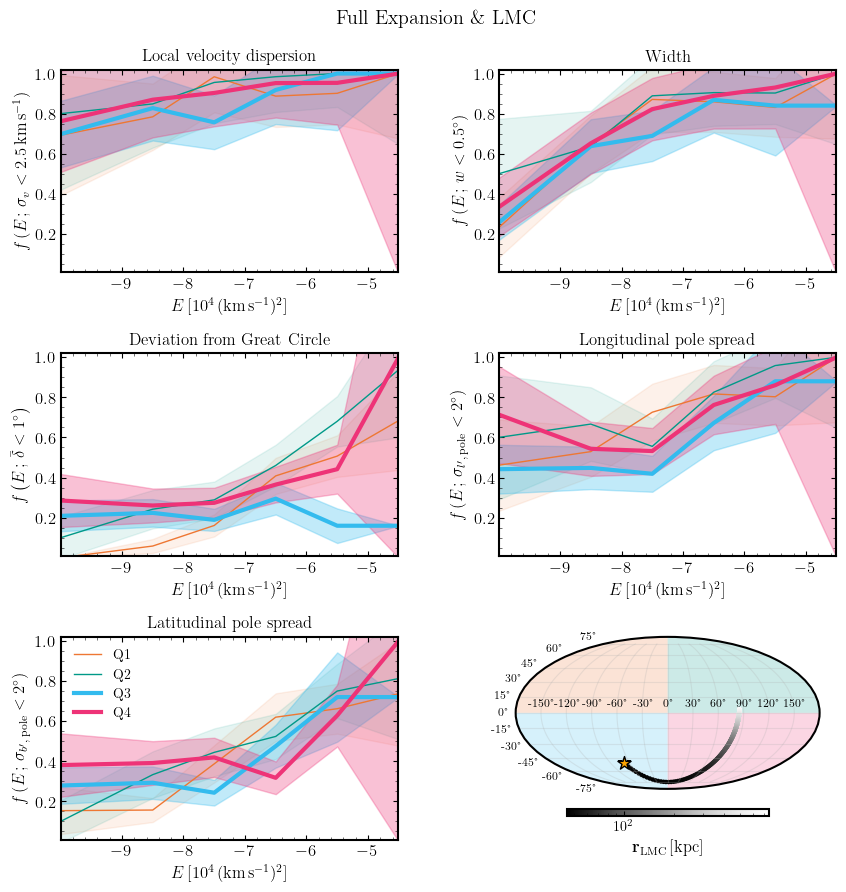

In [21]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
potential = 'Full-MWhalo-MWdisc-LMC.hdf5'
potential_name = 'Full Expansion \& LMC'
# potential = 'full-MWhalo-full-MWdisc-no-LMC.hdf5'
# potential_name = 'Full Expansion (no LMC)'
labels = list(['Q1','Q2','Q3','Q4'])

frac_streams_all_QUAD(path, potential, potential_name, labels, 'frac_streams_combined_quads_fullexps', False)